In [1]:
import pandas as pd
import numpy as np
import ouvrai as ou
from jupyter_dash import JupyterDash
from dash import html, dash_table, dcc, ctx
from dash.dependencies import Input, Output, State
import plotly.express as px
import plotly.graph_objects as go
import plotnine as p9

df, df_sub, df_frame, df_state = ou.load(
    from_pkl=False, file_regex="^data_20230328", pickle=True
)
df_sub = ou.load_demographics(df_sub)
df_frame = ou.compute_kinematics(df_sub, df_frame)
df, df_frame = ou.find_first_velocity_peak(df, df_sub, df_frame)

Reading data_20230328_125706.json
Frame variables are: ['rhOri', 'rhPos', 'state', 't']
State change variables are: ['stateChange', 'stateChangeHeadOri', 'stateChangeHeadPos', 'stateChangeTime']
Expanded cameraGroupOri to ['cameraGroupOri_order' 'cameraGroupOri_x' 'cameraGroupOri_y'
 'cameraGroupOri_z' 'cameraGroupOri_isEuler']
Expanded cameraGroupPosn to ['cameraGroupPosn_x' 'cameraGroupPosn_y' 'cameraGroupPosn_z']
Expanded rotationOrigin to ['rotationOrigin_x' 'rotationOrigin_y' 'rotationOrigin_z']
Expanded rhOri to ['rhOri_w' 'rhOri_x' 'rhOri_y' 'rhOri_z' 'rhOri_isQuaternion']
Expanded rhPos to ['rhPos_x' 'rhPos_y' 'rhPos_z']
Expanded stateChangeHeadOri to ['stateChangeHeadOri_w' 'stateChangeHeadOri_x' 'stateChangeHeadOri_y'
 'stateChangeHeadOri_z' 'stateChangeHeadOri_isQuaternion']
Expanded stateChangeHeadPos to ['stateChangeHeadPos_x' 'stateChangeHeadPos_y' 'stateChangeHeadPos_z']


/Users/evancesanek/Documents/ouvrai/python/ouvrai/ouvrai.py:189: UserWarning: Demographics file not found. You can download it from Prolific.
/Users/evancesanek/Documents/ouvrai/python/ouvrai/ouvrai.py:315: UserWarning: Pre-peak velocity never below pv_thresh (0.018 m/s) for ('000', 32)
/Users/evancesanek/Documents/ouvrai/python/ouvrai/ouvrai.py:315: UserWarning: Pre-peak velocity never below pv_thresh (0.021 m/s) for ('000', 110)
/Users/evancesanek/Documents/ouvrai/python/ouvrai/ouvrai.py:315: UserWarning: Pre-peak velocity never below pv_thresh (0.026 m/s) for ('001', 19)
/Users/evancesanek/Documents/ouvrai/python/ouvrai/ouvrai.py:315: UserWarning: Pre-peak velocity never below pv_thresh (0.013 m/s) for ('006', 89)
/Users/evancesanek/Documents/ouvrai/python/ouvrai/ouvrai.py:315: UserWarning: Pre-peak velocity never below pv_thresh (0.039 m/s) for ('007', 5)


In [2]:
# Label the frames where the state changed
g = df_frame.groupby(["subject", "trialNumber"])["state"]
df_frame["stateChanged"] = g.transform(lambda x: x.shift(1) != x)

In [3]:
# Transform rhPos to the tip of the tool
handleLen = (
    df_frame[["subject"]].merge(
        df_sub[["subject", "handleLength"]], how="left", on="subject"
    )["handleLength"]
    / 2
)
df_frame["rhPos_x"] += df_frame["dir_x"] * handleLen.values
df_frame["rhPos_y"] += df_frame["dir_y"] * handleLen.values
df_frame["rhPos_z"] += df_frame["dir_z"] * handleLen.values

In [4]:
# X is already centered...

# Center Y (individual height calibration)
try:
    df_frame["rhPos_y_orig"]
except KeyError:
    df_frame["rhPos_y_orig"] = df_frame["rhPos_y"]

df_frame["rhPos_y"] = (
    df_frame["rhPos_y_orig"]
    - df_frame[["subject"]].merge(
        df_sub[["subject", "homePosn.y"]], how="left", on=["subject"]
    )["homePosn.y"]
)

# Center Z (same for all participants)
try:
    df_frame["rhPos_z_orig"]
except KeyError:
    df_frame["rhPos_z_orig"] = df_frame["rhPos_z"]

df_frame["rhPos_z"] = (
    df_frame["rhPos_z_orig"]
    - df_frame[["subject"]].merge(
        df_sub[["subject", "homePosn.z"]], how="left", on=["subject"]
    )["homePosn.z"]
)


In [5]:
# Merge per-trial features
try:
    df_frame[["noFeedback"]]
except KeyError:
    df_frame = df_frame.merge(
        df[["subject", "trialNumber", "noFeedback"]],
        how="left",
        on=["subject", "trialNumber"],
    )

In [6]:
# Extract critical frame
critical_distance = 0.17
df_crit = df_frame.groupby(["subject", "trialNumber"]).apply(
    lambda x: x.iloc[
        np.nanargmax((x["distance"] >= critical_distance) | (x["state"] == "RETURN"))
    ]
)
df = df.merge(
    df_crit[["subject", "trialNumber", "t", "rhPos_x", "rhPos_z"]].reset_index(drop=True),
    on=["subject", "trialNumber"],
    how="left",
)
# Compute angle at critical frame
df["angle"] = np.arctan2(df["rhPos_x"], -df["rhPos_z"]) * 180 / np.pi

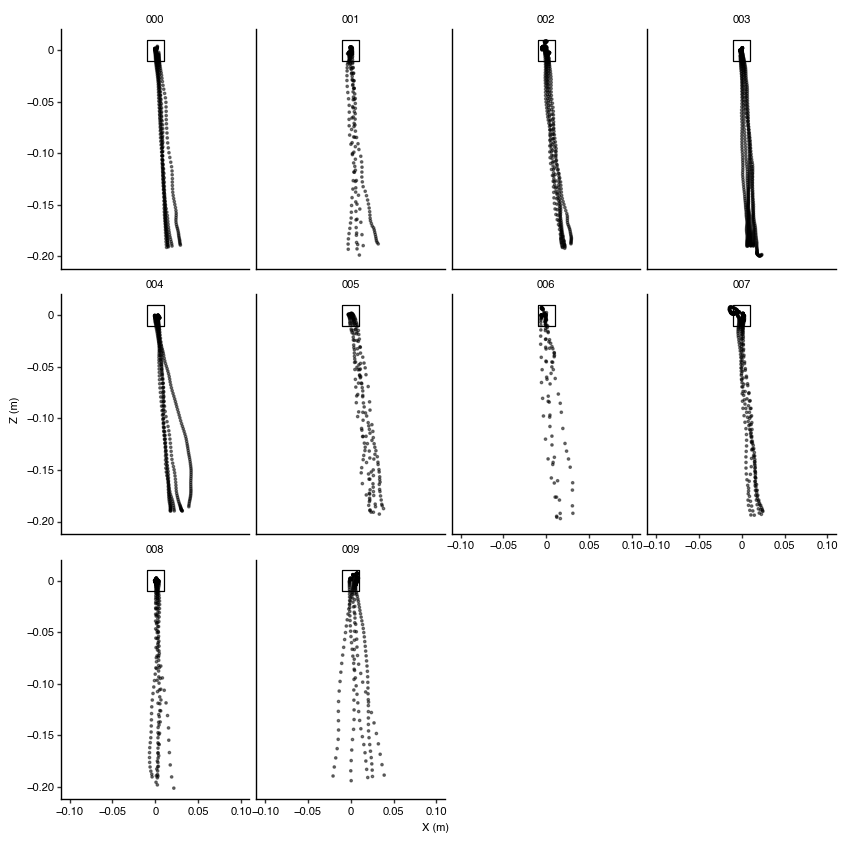

In [12]:
import plotnine as p9

x = df_frame[
    np.isin(df_frame["trialNumber"], [28,98,99,108,109])
    & np.isin(df_frame["state"], ["REACH"])
]
p = (
    p9.ggplot()
    # Trajectories
    + p9.geom_point(
        p9.aes("rhPos_x", "rhPos_z", group="trialNumber"),
        data=x,
        shape=".",
        alpha=0.5,
    )
    # Start cube
    + p9.geom_path(
        p9.aes("x", "y"),
        data=pd.DataFrame(
            {
                "x": [-0.01, 0.01, 0.01, -0.01, -0.01],
                "y": [0.01, 0.01, -0.01, -0.01, 0.01],
            }
        ),
    )
    + p9.theme_classic(base_family="Helvetica")
    + p9.labels.labs(x="X (m)", y="Z (m)")
    + p9.facet_wrap("subject", 3)
    + p9.xlim(-0.1, 0.1)
    + p9.theme(
        legend_position="none",
        figure_size=(10, 10),
        strip_background=p9.element_blank(),
        strip_text_y=p9.element_blank(),
        axis_ticks_minor=p9.element_blank(),
        text=p9.element_text(size=8, color="black"),
    )
)
fig = p.draw(show=True)


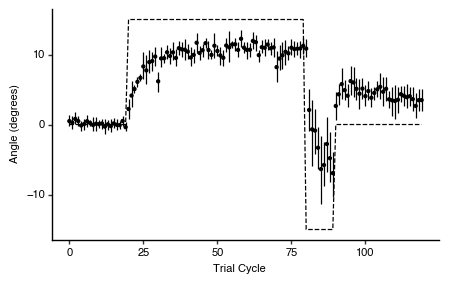

In [14]:
p = (
    p9.ggplot()
    + p9.geom_line(
        p9.aes("cycle", "rotation"),
        data=df,
        linetype="dashed",
    )
    + p9.stat_summary(
        p9.aes(x="cycle", y="angle"),
        data=df,
        shape='.'
    )
    + p9.theme_classic(base_family="Helvetica")
    + p9.labels.labs(x="Trial Cycle", y="Angle (degrees)")
    #+ p9.ylim(-20, 20)
    + p9.theme(
        legend_position="none",
        figure_size=(5, 3),
        strip_background=p9.element_blank(),
        strip_text_y=p9.element_blank(),
        axis_ticks_minor=p9.element_blank(),
        text=p9.element_text(size=8, color="black"),
    )
)
fig = p.draw(show=True)


In [ ]:
app = JupyterDash(__name__)

# Subject-level fields to display in experiment-table
df_sub_main = df_sub[["subject", "workerId", "uid", "date", "userAgent","xrInputProfiles"]]

app.layout = html.Div(
    [
        # Experiment data table
        html.Div(
            [
                dash_table.DataTable(
                    id="experiment-table",
                    data=df_sub_main.to_dict("records"),
                    page_size=10,
                    fixed_columns={"headers": True, "data": 1},
                    style_table={"minWidth": "100%"},
                )
            ],
        ),
        # Participant select
        html.Div(
            [
                html.H3("Choose participant:"),
                dcc.Dropdown(
                    id="participant-dropdown",
                    options=df_sub["subject"],
                    value=df_sub.iloc[0]["subject"],
                    clearable=False,
                    style={"width": "50%"},
                ),
            ],
        ),
        # Plot modifiers
        html.Div(
            [
                html.H4("Enter name of position variable:"),
                dcc.Input(
                    id="position-prefix", value="rhPos", type="text", debounce=True
                ),
                html.H4("Select range of trial cycles to plot:"),
                dcc.RangeSlider(
                    id="participant-trial-slider",
                    min=0,
                    max=df["cycle"].max(),
                    step=1,
                    value=[0, 0],
                    marks={str(x): str(x) for x in np.arange(0, 500, 10)},
                    tooltip={"placement": "bottom", "always_visible": True},
                    pushable=0,
                ),
                html.H4("How do you want to select the critical frame?"),
                dcc.Dropdown(
                    id="critical-frame-type",
                    options=["Time", "Distance"],
                    value="Time",
                ),
                dcc.RadioItems(
                    id="critical-frame-radio", options=["Home", "Onset"], value="Home"
                ),
                html.H4(
                    "Select critical frame:",
                ),
                dcc.Slider(
                    id="critical-frame-slider",
                    min=50,
                    max=300,
                    step=10,
                    marks={str(x): str(x) for x in np.arange(50, 350, 50)},
                    value=150,
                    # tooltip={"placement": "bottom", "always_visible": True},
                ),
                html.H4(
                    "Toggle velocity profile alignment to movement onset:",
                    style={"display": "inline-block"},
                ),
                html.Button(
                    "Align",
                    id="align-velocity",
                    n_clicks=0,
                    style={"margin-left": "20px", "display": "inline-block"},
                ),
            ],
            style={"margin-left": "1%", "width": "48%"},
        ),
        # Plots
        html.Div(
            [
                html.Div(
                    [
                        dcc.Graph(
                            id="participant-trajectory-xz",
                        ),
                        dcc.Graph(
                            id="participant-trajectory-yz",
                        ),
                    ],
                    style={"display": "table-column", "width": "50%"},
                ),
                html.Div(
                    [
                        dcc.Graph(
                            id="participant-velocity",
                        ),
                        dcc.Graph(
                            id="participant-timeline",
                        ),
                    ],
                    style={"width": "50%"},
                ),
            ],
            style={"display": "flex"},
        ),
    ],
    style={"backgroundColor": "white", "padding": "30px"},
)


# Modify critical slider
@app.callback(
    Output("critical-frame-slider", "min"),
    Output("critical-frame-slider", "max"),
    Output("critical-frame-slider", "step"),
    Output("critical-frame-slider", "marks"),
    Output("critical-frame-slider", "value"),
    Input("critical-frame-type", "value"),
)
def switch_critical_frame_type(type):
    min_d = 0.05
    max_d = df_sub.loc[0, "targetDistance"]
    step_d = 0.005
    markstep_d = 0.025
    min_t = 50
    max_t = 300
    step_t = 10
    markstep_t = 50

    if type == "Time":
        return (
            min_t,
            max_t,
            step_t,
            {str(x): str(x) for x in np.arange(min_t, max_t + markstep_t, markstep_t)},
            150,
        )
    elif type == "Distance":
        return (
            min_d,
            max_d,
            step_d,
            {
                str(x): str(np.round(x, 3))
                for x in np.linspace(
                    min_d, max_d, int(np.floor((max_d - min_d) / markstep_d)) + 1
                )
            },
            0.075,
        )


# When a participant is selected
@app.callback(
    Output("participant-trajectory-xz", "figure"),
    Output("participant-trajectory-yz", "figure"),
    Output("participant-velocity", "figure"),
    Output("participant-timeline", "figure"),
    Output("align-velocity", "children"),
    Input("participant-trial-slider", "value"),
    Input("critical-frame-type", "value"),
    Input("critical-frame-radio", "value"),
    Input("critical-frame-slider", "value"),
    Input("participant-velocity", "clickData"),
    Input("participant-trajectory-xz", "clickData"),
    Input("align-velocity", "n_clicks"),
    Input("participant-dropdown", "value"),
    State("position-prefix", "value"),
)
def generate_figures(
    cycles,
    critical_frame_type,
    critical_frame_radio,
    critical_frame_val,
    click_vel,
    click_traj,
    align,
    subject,
    prefix,
):
    dff = df[df["subject"] == subject]
    dff_frame = df_frame[df_frame["subject"] == subject]

    xname = f"{prefix}_x"
    yname = f"{prefix}_y"
    zname = f"{prefix}_z"

    align = (align) % 2

    # Compute critical frame and timeline
    # Have to do this before subsetting in order to see all trials
    if critical_frame_type == "Time":
        df_crit = dff_frame.groupby("trialNumber").apply(
            ou.get_nearest_row, varname="t_onset", value=critical_frame_val
        )
    elif critical_frame_type == "Distance":
        df_crit = dff_frame.groupby("trialNumber").apply(
            lambda x: x.iloc[
                np.nanargmax(
                    (x["distance"] >= critical_frame_val) | (x["state"] == "RETURN")
                )
            ]
        )
    # Merge these critical values into dff ( == dff[[xname, yname, zname]])
    dff = dff.merge(
        df_crit[["trialNumber", "t", xname, zname, "velocity", "dir_x", "dir_y", "dir_z"]].reset_index(drop=True),
        on="trialNumber",
        how="left",
    )

    # TODO: BETTER NAMES FOR ADDING ORIENTATION TO CRITICAL FRAME POSITION
    dff['tmp_x'] = dff[xname]+dff['dir_x']*.045
    dff['tmp_z'] = dff[zname]+dff['dir_z']*.045

    # Get the onset frame (onset_pv is a boolean mask)
    onset_data = dff_frame[dff_frame["onset_pv"]]
    if critical_frame_radio == "Home":
        compare_x = df_sub.loc[df_sub["subject"] == subject, "homePosn.x"].values[0]
        compare_z = df_sub.loc[df_sub["subject"] == subject, "homePosn.z"].values[0]
    elif critical_frame_radio == "Onset":
        compare_x = onset_data[xname].values
        compare_z = onset_data[zname].values
    # Compute the aiming angles for all trials for selected subject
    # print(compare_x,compare_z)
    dff["crit_x"] = dff[xname] - compare_x
    dff["crit_z"] = dff[zname] - compare_z
    dff["angle"] = np.arctan2(dff["crit_x"], -dff["crit_z"]) * 180 / np.pi

    # Now we can subset by cycle
    dfff = dff[np.isin(dff["cycle"], np.arange(cycles[0], cycles[1] + 1))]
    dff_frame = dff_frame.loc[
        np.isin(dff_frame["cycle"], np.arange(cycles[0], cycles[1] + 1))
    ]
    onset_data = onset_data.loc[
        np.isin(onset_data["cycle"], np.arange(cycles[0], cycles[1] + 1))
    ]

    def add_points(xname, yname, customnames, dff, color="purple", fill=False):
        return go.Scatter(
            x=[dff[xname]],
            y=[dff[yname]],
            mode="markers",
            marker_color=color if fill else "white",
            marker_line_color=color,
            marker_line_width=2,
            customdata=np.array([dff[customnames]]),
            showlegend=False,
        )

    def fade_unselected_traces(fig, opacity=0.1):
        fig.update_traces(
            patch={"opacity": opacity},
            selector=(
                lambda x: (
                    x["customdata"][0] != click_vel["points"][0]["customdata"]
                ).any()
            ),
        )

    # Plot
    trajxz_fig = px.line(
        dff_frame,
        y=xname,
        x=zname,
        color="targetId",
        line_group="trialNumber",
        line_dash="state",
        line_dash_map={"DELAY": "dot", "REACH": "solid", "RETURN": "dot"},
        markers=False,
        category_orders={"targetId": [0, 1]},
        custom_data=["cycle", "targetId"],
    )
    for i, r in onset_data.iterrows():
        trajxz_fig.add_trace(
            add_points(zname, xname, ["cycle", "targetId"], r, color="green", fill=True)
        )
    for i, r in dfff.iterrows():
        trajxz_fig.add_trace(
            add_points(zname, xname, ["cycle", "targetId"], r, color="black")
        )  # could also do this with "rotationOrigin.z", "rotationOrigin.x",
        trajxz_fig.add_trace(
            add_points("tmp_z", "tmp_x", ["cycle", "targetId"], r, color="orange",fill=True)
        )

    trajxz_fig.update_xaxes(autorange="reversed")
    trajxz_fig.update_yaxes(autorange="reversed", scaleanchor="x", scaleratio=1)

    trajyz_fig = px.line(
        dff_frame,
        y=yname,
        x=zname,
        color="targetId",
        line_group="trialNumber",
        line_dash="state",
        line_dash_map={"DELAY": "dot", "REACH": "solid", "RETURN": "dot"},
        markers=False,
        category_orders={"targetId": [0, 1]},
        custom_data=["cycle", "targetId"],
    )
    for i, r in onset_data.iterrows():
        trajyz_fig.add_trace(
            add_points(zname, yname, ["cycle", "targetId"], r, color="green", fill=True)
        )
    trajyz_fig.update_xaxes(autorange="reversed")
    trajyz_fig.update_yaxes(scaleanchor="x", scaleratio=1)

    vel_fig = px.line(
        dff_frame,
        x="t_onset" if align else "t",
        y="velocity",
        color="targetId",
        line_group="trialNumber",
        line_dash="state",
        line_dash_map={"DELAY": "dot", "REACH": "solid", "RETURN": "dot"},
        category_orders={"targetId": [0, 1]},
        custom_data=["cycle", "targetId"],
    )
    for i, r in dfff.iterrows():
        if align:
            r["t"] -= r["t_onset_pv"]
        vel_fig.add_trace(
            add_points("t", "velocity", ["cycle", "targetId"], r, color="black")
        )
    if not align:
        for i, r in onset_data.iterrows():
            vel_fig.add_trace(
                add_points(
                    "t", "velocity", ["cycle", "targetId"], r, color="green", fill=True
                )
            )

    timeline_fig = px.line(
        dff,
        x="cycle",
        y="angle",
        color="targetId",
        category_orders={"targetId": [0, 1]},
        markers=True,
    )
    timeline_rotation = px.line(
        dff,
        x="cycle",
        y="rotation",
        color="targetId",
        category_orders={"targetId": [0, 1]},
    )
    timeline_rotation.update_traces({"line": {"dash": "dash"}})
    timeline_fig.add_traces(timeline_rotation.data)
    if "participant-velocity.clickData" in ctx.triggered_prop_ids:
        selected_cycle = click_vel["points"][0]["customdata"][0]
        selected_targetId = click_vel["points"][0]["customdata"][1]

        fade_unselected_traces(trajxz_fig)
        fade_unselected_traces(trajyz_fig)
        fade_unselected_traces(vel_fig)

        timeline_fig.update_traces(
            patch={"opacity": 0.1},
            selector=(lambda x: x["name"] != str(selected_targetId)),
        )
        highlight_point = px.scatter(
            dff.loc[
                (dff["cycle"] == selected_cycle)
                & (dff["targetId"] == selected_targetId)
            ],
            x="cycle",
            y="angle",
        ).data[0]
        highlight_point.marker.color = "white"
        highlight_point.marker.line.color = "black"
        highlight_point.marker.line.width = 2
        highlight_point.marker.size = 8
        timeline_fig.add_trace(highlight_point)

    if "participant-trajectory-xz.clickData" in ctx.triggered_prop_ids:
        print(click_traj)

    return (
        trajxz_fig,
        trajyz_fig,
        vel_fig,
        timeline_fig,
        "Reset" if align else "Align",
    )


In [ ]:
app.run_server(host="localhost", debug=True)